In [1]:
# Standard library imports
import os
import warnings
from datetime import datetime

# Data processing and numerical libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
import dask.dataframe as dd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils import resample
from joblib import Parallel, delayed

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and recommendation libraries
import torch
import mlflow
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from tqdm import tqdm  # Import tqdm for progress bar


# IPython for displaying outputs
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')


/Users/matthewaudley/Documents/Machine Learning Projects/Business Recommendation System/brs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Initialize a SparkSession
# spark = SparkSession.builder \
#     .appName("MySparkApp") \
#     .config("spark.some.config.option", "config-value") \
#     .getOrCreate()

# # Check the Spark session
# print(spark)

In [3]:
local_path = f"../../data/processed/"

# # Load data and set indices
data_businesses = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_business.parquet"))
data_checkin = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_checkin.parquet"))
data_tip = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_tip.parquet"))
data_review = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_review.parquet"))
data_user = pd.read_parquet(os.path.join(local_path, "yelp_academic_dataset_user.parquet"))

df_dict = {
    'bus_df': data_businesses,
    'checkin_df': data_checkin,
    'tip_df': data_tip,
    'review_df': data_review,
    'user_df': data_user
}



In [4]:
# Data transformations

current_time = datetime.now()
scaler = StandardScaler()
optimal_num_clusters = 11
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', max_iter=100, n_init=10, random_state=42)


data_user['yelping_since'] = pd.to_datetime(data_user['yelping_since'])
data_user['years_yelp_member'] = ((current_time - data_user['yelping_since']).dt.days)/365
data_user = data_user.rename(columns={'average_stars': 'user_avg_rating', 'review_count': 'user_review_count'})



data_review['date'] = pd.to_datetime(data_review['date'])
data_review['years_since_review'] = ((current_time-data_review['date']).dt.days)/365
data_review['day_of_week'] = data_review['date'].dt.day_of_week
data_review['day_of_year'] = data_review['date'].dt.day_of_year
data_review['clean_text'] = (
    data_review['text']
    .str.strip()                           
    .str.replace(r'\d+', '', regex=True)  
    .str.lower()                            
    .str.replace(r'[^\w\s]', '', regex=True)  
)
data_review = data_review.rename(columns={'stars': 'rating'})

data_businesses[['latitude_scaled', 'longitude_scaled']] = scaler.fit_transform(data_businesses[['latitude', 'longitude']])
data_businesses['region_code'] = kmeans.fit_predict(data_businesses[['latitude_scaled', 'longitude_scaled']].values)


state_ids, unique_states = pd.factorize(data_businesses['state'].str.lower())
data_businesses['state_code'] = state_ids
city_ids, unique_cities = pd.factorize(data_businesses['city'].str.lower())
data_businesses['city_code'] = city_ids
data_businesses = data_businesses.rename(columns={'stars': 'bus_avg_rating', 'review_count':'business_review_count'}) 

Inertias: (161417.47839987747, 77188.89031080666, 38507.438297997556, 21608.058664077154, 8918.454830356612, 6259.178502146468, 3979.8359602463997, 2331.7941311110458, 790.1793525016164, 77.5928212147926, 59.30152232664311, 48.98914643648957, 44.86664682845268, 39.31141099710083, 37.08663265073166, 33.72863147504518, 31.104866453110308, 30.381678018737468)
Silhouette Scores: (np.float64(0.5734312266643972), np.float64(0.6796504220876628), np.float64(0.722719093066207), np.float64(0.7770451576765638), np.float64(0.8173140676300488), np.float64(0.8439763492936018), np.float64(0.8730355724168559), np.float64(0.891726770920608), np.float64(0.9172158992841858), np.float64(0.9565995400173583), np.float64(0.8082620378765829), np.float64(0.7188844028721464), np.float64(0.702989655128938), np.float64(0.7137372215818277), np.float64(0.7071765419758371), np.float64(0.6536986609777629), np.float64(0.6383563108112891), np.float64(0.6568241627694672))


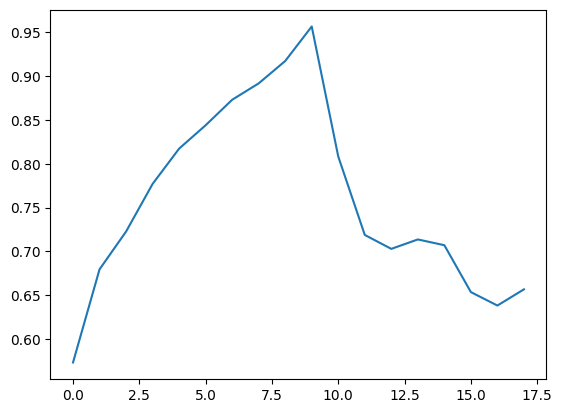

In [9]:
# cluster business's by positional data

# sample a fraction of the data to calculate silhouette score
def compute_kmeans_silhouette(k, data, sample_size=1000):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # resample the data for faster silhouette score computation
    if len(data) > sample_size:
        data_sample, labels_sample = resample(data, cluster_labels, n_samples=sample_size, random_state=42)
        sil_score = silhouette_score(data_sample, labels_sample)
    else:
        sil_score = silhouette_score(data, cluster_labels)

    return kmeans.inertia_, sil_score

results = Parallel(n_jobs=-1)(delayed(compute_kmeans_silhouette)(k, data_businesses[['latitude_scaled', 'longitude_scaled']].values, sample_size=20000) for k in range(2, 20))
inertias, sil_scores = zip(*results)

plt.plot(sil_scores)
optimal_num_clusters = 11


,user_id,business_id,clean_text,years_since_review,day_of_week,day_of_year,years_yelp_member,user_review_count,user_avg_rating,bus_avg_rating,business_review_count,region_code,state_code,city_code,categories_enc,mean_centered_rating
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,if you decide to eat here just be aware it is ...,6.200000,5,188,8.682192,33,4.06,3.0,169,0,3,146,"[351, 562, 1116, 57, 175, 1044, 1223, 0, 0, 0,...",-1.06
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,ive taken a lot of spin classes over the years...,12.712329,1,3,13.539726,10,4.30,5.0,144,0,3,3,"[984, 217, 1297, 1036, 574, 0, 0, 0, 0, 0, 0, ...",0.70
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,family diner had the buffet eclectic assortmen...,10.619178,2,36,12.041096,1332,4.69,3.5,47,3,2,2,"[351, 562, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-1.69
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,wow yummy different delicious our favorite...,9.709589,6,4,10.671233,9,4.78,4.0,181,0,3,3,"[397, 447, 351, 1256, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.22
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,cute interior and owner gave us tour of upcom...,7.676712,5,14,16.430137,126,2.97,4.0,32,2,7,14,"[1223, 269, 498, 631, 1116, 351, 236, 1034, 0,...",1.03


In [11]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()


pre_norm_df['log_business_review_count'] = np.log1p(pre_norm_df['business_review_count'])
pre_norm_df['log_user_review_count'] = np.log1p(pre_norm_df['user_review_count'])

norm_df = pre_norm_df.copy()
norm_df[['user_avg_rating_norm', 'bus_avg_rating_norm']] = mm_scaler.fit_transform(norm_df[['user_avg_rating', 'bus_avg_rating']])
norm_df[['log_business_review_count_norm', 'log_user_review_count_norm', 'years_yelp_member_norm', 'years_since_review_norm']] = std_scaler.fit_transform(norm_df[['log_business_review_count', 'log_user_review_count', 'years_yelp_member', 'years_since_review']])
norm_df = norm_df.drop(columns=['years_since_review', 'years_yelp_member', 'user_avg_rating', 'bus_avg_rating', 'log_business_review_count', 'log_user_review_count', 'user_review_count', 'business_review_count'])

# Get the mapping of categories to numbers

norm_df['user_num_id'] = user_encoder.fit_transform(norm_df['user_id'])
norm_df['bus_num_id'] = business_encoder.fit_transform(norm_df['business_id'])
pre_token_df = norm_df.drop(columns=['user_id', 'business_id'])


user_mapping = norm_df.groupby(['user_id'])['user_num_id'].first().reset_index()
business_mapping = norm_df.groupby(['business_id'])['bus_num_id'].first().reset_index()


business_mapping.to_parquet(os.path.join(local_path,'business_mapping.parquet'))
user_mapping.to_parquet(os.path.join(local_path,'user_mapping.parquet'))

In [4]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization function
def batch_encode(text_batch):
    return tokenizer(
        text_batch,
        padding='max_length',
        add_special_tokens=False,
        max_length=10,
        truncation=True,
        return_tensors="np",
        return_token_type_ids=False,
        return_attention_mask=False
    )


batch_size = 2000 
all_encoded = []

num_batches = len(pre_token_df) // batch_size 

# iterate over batches with a progress bar
for i in tqdm(range(0, len(pre_token_df), batch_size), desc="Tokenizing", total=num_batches):
    batch = pre_token_df['clean_text'][i:i + batch_size].tolist()
    encoded = batch_encode(batch)
    all_encoded.append(encoded['input_ids'])


input_ids = np.concatenate(all_encoded, axis=0)


Tokenizing: 2197it [04:36,  7.95it/s]                          


In [236]:
pretense_df.to_parquet("/Users/matthewaudley/Documents/Machine Learning Projects/Business Recommendation System/data/processed/Final Dataframes/final_df.parquet")

In [2]:
import pandas as pd
import os

local_path = './../../data/processed/Final Dataframes/'
final_df = pd.read_parquet(os.path.join(local_path, "final_df.parquet"))

In [3]:
final_df.columns

Index(['day_of_week', 'day_of_year', 'region_code', 'state_code', 'city_code',
       'mean_centered_rating', 'user_avg_rating_norm', 'bus_avg_rating_norm',
       'log_business_review_count_norm', 'log_user_review_count_norm',
       'years_yelp_member_norm', 'years_since_review_norm', 'user_num_id',
       'bus_num_id', 'tokens'],
      dtype='object')

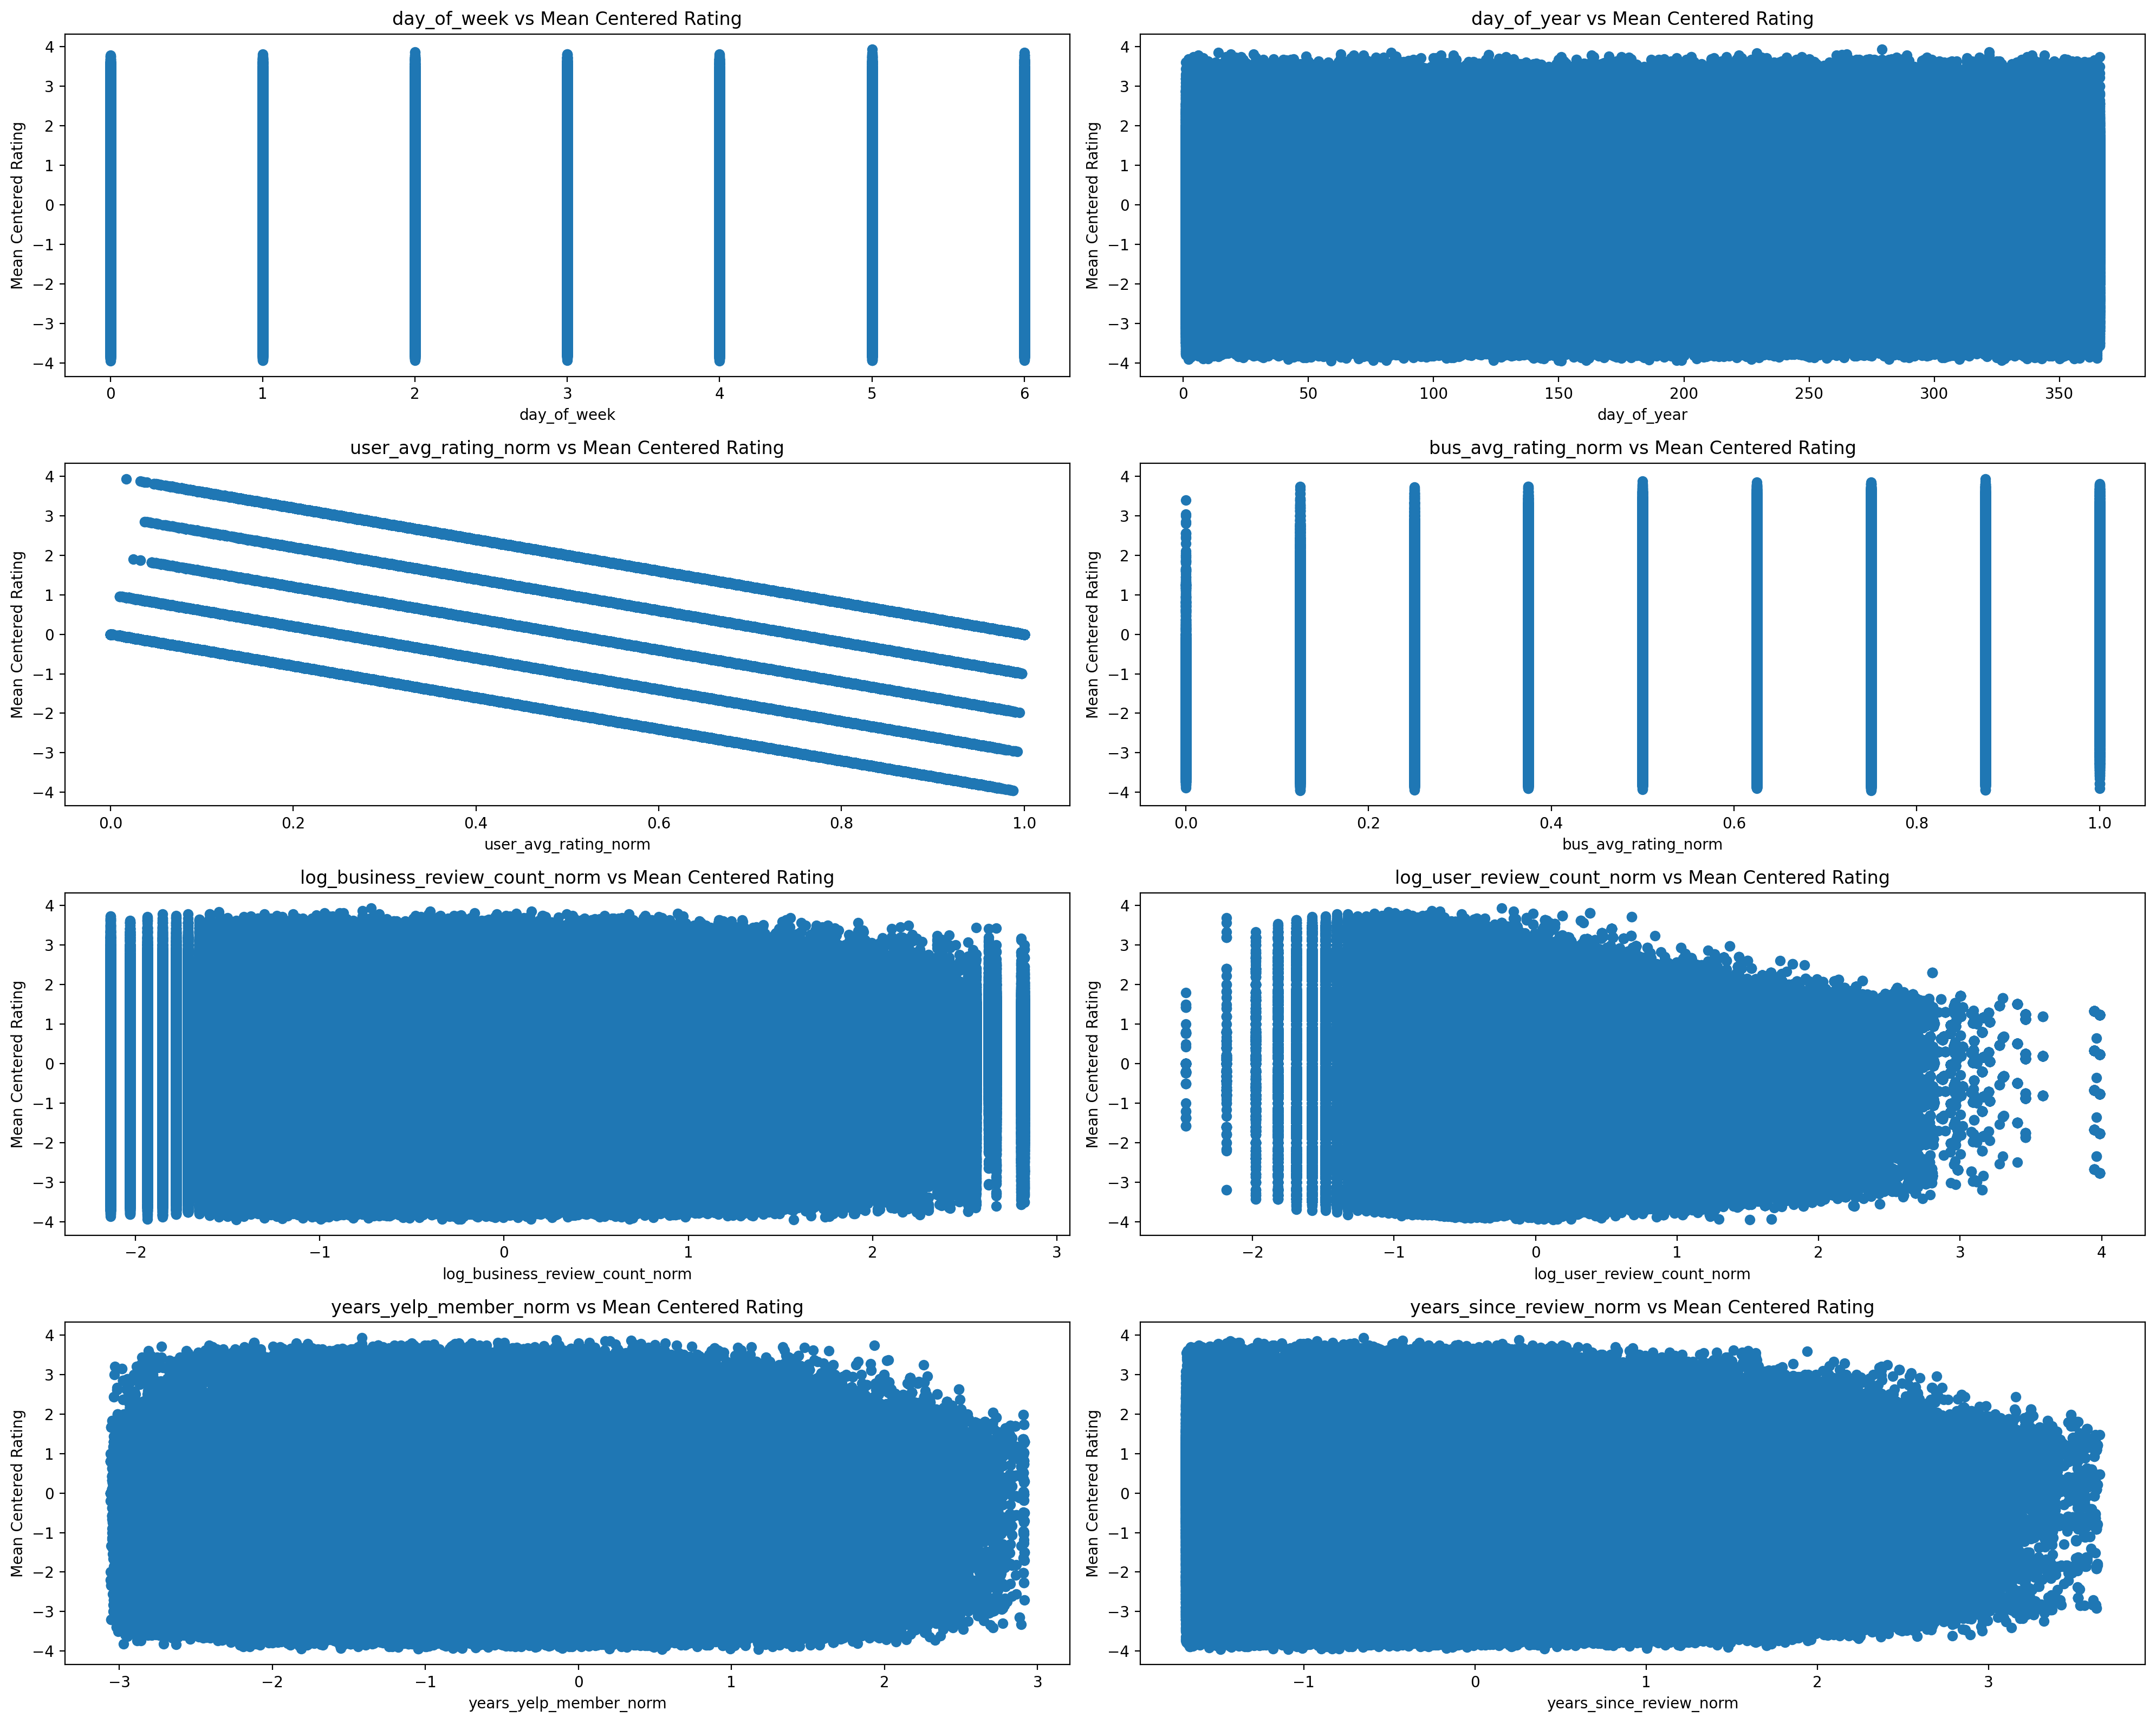

In [4]:
# # Define your numerical features and target
# numerical_features = ['day_of_week', 'day_of_year', 'user_avg_rating_norm', 'bus_avg_rating_norm',
#                       'log_business_review_count_norm', 'log_user_review_count_norm',
#                       'years_yelp_member_norm', 'years_since_review_norm']
# target = final_df['mean_centered_rating']

# # Create 4x2 subplots (8 total)
# fig, axes = plt.subplots(4, 2, figsize=(20, 16), dpi=200)
# ax = axes.ravel()  # Flatten the 2D array of axes

# # Iterate over each feature and corresponding axis to plot
# for i in range(len(ax)):
#     ax[i].plot(final_df[numerical_features[i]], target, 'o')
#     ax[i].set_title(f"{numerical_features[i]} vs Mean Centered Rating")
#     ax[i].set_xlabel(numerical_features[i])
#     ax[i].set_ylabel('Mean Centered Rating')

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

In [10]:
corr = final_df[numerical_features + ['mean_centered_rating']].corr()
corr

,day_of_week,day_of_year,user_avg_rating_norm,bus_avg_rating_norm,log_business_review_count_norm,log_user_review_count_norm,years_yelp_member_norm,years_since_review_norm,mean_centered_rating
day_of_week,1.000000,-0.008791,0.001002,0.011287,0.007342,-0.045565,-0.042845,-0.053659,-0.000950
day_of_year,-0.008791,1.000000,-0.002962,-0.000338,-0.010548,0.002775,-0.014663,-0.042574,-0.003852
user_avg_rating_norm,0.001002,-0.002962,1.000000,0.221885,0.091798,0.107367,-0.044721,-0.057052,-0.009095
bus_avg_rating_norm,0.011287,-0.000338,0.221885,1.000000,0.218181,0.022047,-0.013129,-0.101575,0.392171
log_business_review_count_norm,0.007342,-0.010548,0.091798,0.218181,1.000000,0.072864,0.029620,0.036372,0.064384
log_user_review_count_norm,-0.045565,0.002775,0.107367,0.022047,0.072864,1.000000,0.367135,0.161483,-0.002794
years_yelp_member_norm,-0.042845,-0.014663,-0.044721,-0.013129,0.029620,0.367135,1.000000,0.574098,0.003633
years_since_review_norm,-0.053659,-0.042574,-0.057052,-0.101575,0.036372,0.161483,0.574098,1.000000,-0.020591
mean_centered_rating,-0.000950,-0.003852,-0.009095,0.392171,0.064384,-0.002794,0.003633,-0.020591,1.000000


<Axes: >

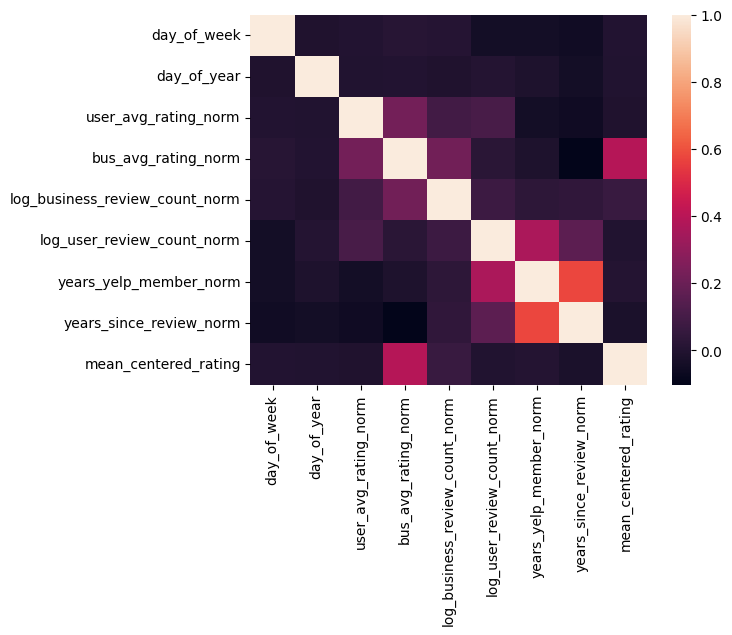

In [11]:
sns.heatmap(corr)

In [228]:
from sklearn.model_selection import train_test_split


train, val_test = train_test_split(pretense_df, test_size=.2)
val, test = train_test_split(val_test, test_size=.5)

EVR by Component:  [0.29522512 0.23251672 0.15567174 0.13253652 0.12171432 0.06233558]
Cumulative Explained Variance:  [0.29522512 0.52774184 0.68341358 0.8159501  0.93766442 1.        ]


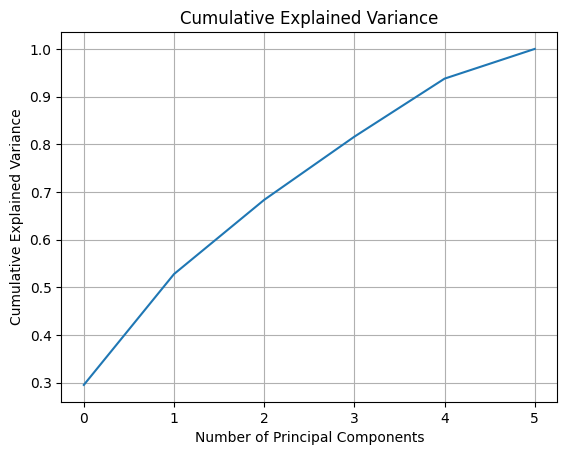

In [138]:
pca = PCA()
result = pca.fit_transform(final_df[numerical_features])

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


print("EVR by Component: ", explained_variance_ratio)
print("Cumulative Explained Variance: ", cumulative_explained_variance)

pca_cols = result[:, :5]

In [164]:
scaler = StandardScaler()
pca_cols = result[:, :5]

pca_norm = scaler.fit_transform(pca_cols)
pca_df = pd.DataFrame(pca_norm)
pca_df.index = final_df.index
pca_df.columns = [f"pca_{num}" for num in range(1, 6)]

pretense_df = pd.concat((final_df, pca_df), axis=1)


In [234]:
# Continuous Data
numerical_features = ['log_business_review_count_norm',
       'log_user_review_count_norm', 'user_avg_rating_norm',
       'bus_avg_rating_norm', 'years_yelp_member_norm',
       'years_since_review_norm']

pca_features = [f"pca_{num}" for num in range(1, 6)]

# Discrete Data
ids_features = ['user_num_id', 'business_num_id']

embeddings = ['region_code', 'state_code', 'city_code',
              'day_of_year', 'day_of_week']

categories_encoding = ['categories_enc']

tokens_encoding = ['tokens']


target = ['mean_centered_rating']


instructions = {
    'numerical_features': {
        'data': numerical_features,
        'type': 'continuous' 
    },
    'ids': {
        'data': ids_features,
        'type': 'discrete'  
    },
    'category_encoding': {
        'data': categories_encoding,
        'type': 'discrete'  
    },
    'token_encoding': {
        'data': tokens_encoding,
        'type': 'discrete'  
    },
    'pca_features': {
        'data': pca_features,
        'type': 'continuous'  
    },
    'target': {
        'data': target,
        'type': 'continuous' #treating as continuous  
    }
}


In [235]:
def build_tensor(feature_list, data_type, train, val, test):
    
    dtype = torch.float32 if data_type == 'continuous' else torch.long
    # avoid error where querying df with single col returns df, not series..
    feature_list = feature_list if len(feature_list) > 1 else feature_list[0]
    
        
    train_tensor = torch.tensor(train[feature_list].values.tolist(), dtype=dtype)
    val_tensor = torch.tensor(val[feature_list].values.tolist(), dtype=dtype)
    test_tensor = torch.tensor(test[feature_list].values.tolist(), dtype=dtype)
    
    return train_tensor,val_tensor,test_tensor

# split according to instructions
def split_to_tensors(instruct, path, train, val, test):
    for name, data in instruct.items():
        train_tensor, val_tensor, test_tensor = build_tensor(data['data'], data['type'], train, val, test)
        torch.save(train_tensor, os.path.join(path, f"train_{name}.pt"))
        torch.save(val_tensor, os.path.join(path, f"val_{name}.pt"))
        torch.save(test_tensor,os.path.join(path, f"test_{name}.pt"))
    
save_path = f"../../data/processed/Final Tensors"

split_to_tensors(instructions, save_path, train, val, test)
    